In [39]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pymaster as nmt
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [3]:
plot_dir = '../plots/2023-01-25_figures'
save = True

# Gaia DR3 QSO candidate viz

In [24]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


In [25]:
fn_gaia_all = '../data/gaia_slim_xsdss.fits'
tab_gaia_all = utils.load_table(fn_gaia_all)
N_data_all = len(tab_gaia_all)
print(f"Number of data sources: {N_data_all}")


Number of data sources: 6649162


In [128]:
map_nqso_all, _ = maps.get_map(NSIDE, tab_gaia_all['ra'], tab_gaia_all['dec'], null_val=0)
map_ndens_all = map_nqso_all/area_per_pixel
map_ndens_all_masked = hp.ma(map_ndens_all)
map_ndens_all_masked.mask = map_ndens_all==0

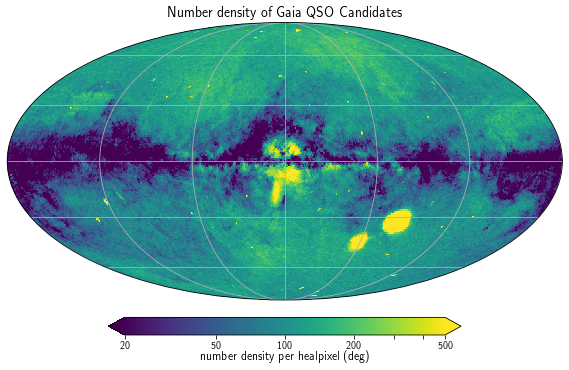

In [236]:
projview(map_ndens_all_masked, title=rf"Number density of Gaia QSO Candidates",
            unit=r"number density per healpixel (deg)", cmap='viridis', coord=['C', 'G'], 
            min=20, max=500, norm='log', graticule=True,
           show_tickmarkers=True, cbar_ticks=[20, 50, 100, 200, 500])

fn = f'{plot_dir}/gaia_qso_candidates_2d.png'
if save:
    plt.savefig(fn)

# Purer sample

In [215]:
fn_gaia_purer = '/scratch/ksf293/gaia-quasars-lss/data/gaia_purer.fits'
tab_gaia_purer_full = utils.load_table(fn_gaia_purer)
print(len(tab_gaia_purer_full))

1942825


In [216]:
tab_gaia_purer_full.keep_columns(['source_id'])

In [217]:
tab_gaia_purer = astropy.table.join(tab_gaia_all, tab_gaia_purer_full, keys=['source_id'], 
                         join_type='inner')
N_data_purer = len(tab_gaia_purer)
print(f"Number of data sources: {N_data_purer}")
print(tab_gaia_purer.columns)

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','allwise_oid','w1mpro','w2mpro','g_rp','bp_g','bp_rp','g_w1','w1_w2','ebv','A_v','pm','sdss_SDSS_NAME','sdss_OBJID','sdss_THING_ID','sdss_RA','sdss_DEC','sdss_Z')>
Number of data sources: 1942825
<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','allwise_oid','w1mpro','w2mpro','g_rp','bp_g','bp_rp','g_w1','w1_w2','ebv','A_v','pm','sdss_SDSS_NAME','sdss_OBJID','sdss_THING_ID','sdss_RA','sdss_DEC','sdss_Z')>


In [218]:
map_nqso_purer, _ = maps.get_map(NSIDE, tab_gaia_purer['ra'], tab_gaia_purer['dec'], null_val=0)

In [219]:
map_ndens_purer = map_nqso_purer/area_per_pixel

In [222]:
map_ndens_purer_masked = hp.ma(map_ndens_purer)
map_ndens_purer_masked.mask = map_ndens_purer==0

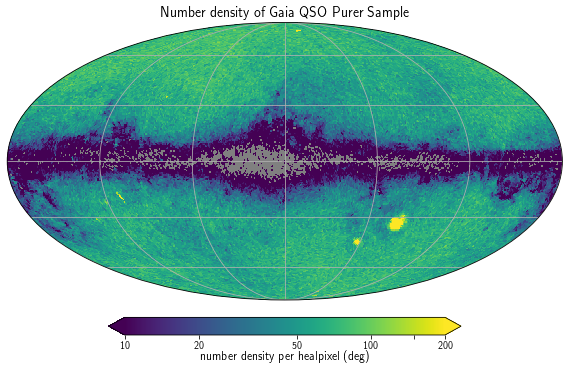

In [341]:
projview(map_ndens_purer_masked, title=rf"Number density of Gaia QSO Purer Sample",
            unit=r"number density per healpixel (deg)", cmap='viridis', coord=['C', 'G'], 
            min=10, max=200, norm='log', graticule=True,
           show_tickmarkers=True, cbar_ticks=[10, 20, 50, 100, 200])

fn = f'{plot_dir}/gaia_qsos_purer_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# Color cuts

In [27]:
# TODO: better cuts! 
cut_0 = 0., 1., 0.2
cut_1 = 1., 1., 2.9

In [28]:
# cut: (a, b, c) where ax+by=c
def plot_cut(ax, cut, x_eq=None, only_plot=None):

    xx = np.array(ax.get_xlim())
    yy = np.array(ax.get_ylim())
    
    if only_plot=='above':
        xx[0] = x_eq
    if only_plot=='below':
        xx[1] = x_eq

    idx_plot = np.arange(len(xx))
    if abs(cut[0]) > abs(cut[1]):
        # solve ax+by=c for x: (c-by)/a
        xcut = (cut[2] - cut[1]*yy)/cut[0]
        ax.plot(xcut, yy, 'k-', lw=0.7)
    else:
        # solve ax+by=c for y: (c-ax)/b
        ycut = (cut[2] - cut[0]*xx)/cut[1]
        ax.plot(xx, ycut, 'k-', lw=0.7)
        

def cut_index(g_w1, w1_w2, cut):
    return cut[0] * g_w1 + cut[1] * w1_w2 > cut[2]

In [27]:
fn_sdss_full = '../data/SDSS_DR16Q_v4.fits'
tab_sdss_full = Table.read(fn_sdss_full, format='fits')

In [28]:
g_sdss = tab_sdss_full['GAIA_G_MAG']
w1_sdss = tab_sdss_full['W1_MAG']
w2_sdss = tab_sdss_full['W2_MAG']

In [91]:
idx_nog = np.abs(1+g_sdss)<1e-6
idx_nowise = (np.abs(1+w1_sdss)<1e-6) | (np.abs(1+w2_sdss)<1e-6)
print(np.sum(idx_nog))
print(np.sum(~idx_nog))
print(np.sum(idx_nowise))

print(np.sum(~idx_nog & (g_sdss<20.4)))

280640
469774
1034
276404


In [92]:
idx_hasphot = ~idx_nog & ~idx_nowise
print(np.sum(idx_hasphot))

467785


In [29]:
color_cuts = [cut_0, cut_1]
idx_clean_gaia = utils.gw1_w1w2_cuts_index(tab_gaia_all, color_cuts)
print(np.sum(idx_clean_gaia))

Fraction that make cuts: 0.239
1590088


2.6999999999999997


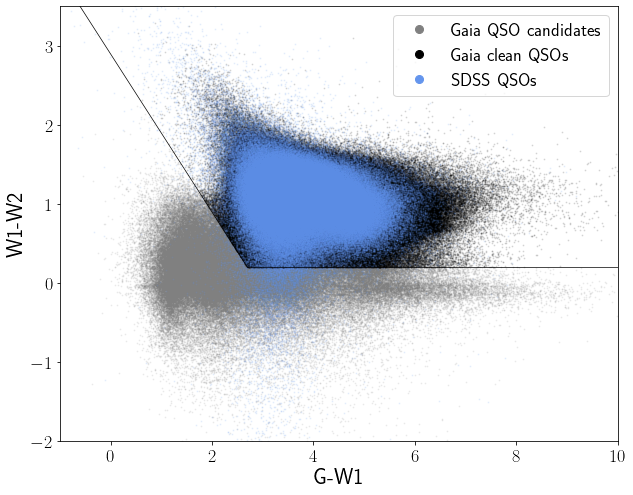

In [335]:
plt.figure(figsize=(10,8))

colors = ['grey', 'black', 'cornflowerblue']
labels = ['Gaia QSO candidates', 'Gaia clean QSOs', 'SDSS QSOs']
plt.scatter(tab_gaia_all['g_w1'][~idx_clean_gaia], tab_gaia_all['w1_w2'][~idx_clean_gaia], 
            color=colors[0], s=1, alpha=0.1, label=labels[0])
plt.scatter(tab_gaia_all['g_w1'][idx_clean_gaia], tab_gaia_all['w1_w2'][idx_clean_gaia], 
            color=colors[1], s=1, alpha=0.1, label=labels[1])
plt.scatter((g_sdss-w1_sdss)[idx_hasphot], (w1_sdss-w2_sdss)[idx_hasphot], 
            color=colors[2], s=1, alpha=0.1, label=labels[2])

#for i in range(len(tables)):
    #g_w1, w1_w2, g, w1, w2 = get_gaia_wise_colors(tables[i], key_mode=None)
    #plt.scatter(g_w1, w1_w2, s=1, alpha=0.1, color=colors[i], label=labels[i], zorder=zorders[i])

# plot cuts
ax = plt.gca()

#y_eq = (cut_0[2]*cut_1[0] - cut_1[2]*cut_0[0])/(cut_0[1]*cut_1[0] - cut_1[1]*cut_0[0])
x_eq = (cut_0[2]*cut_1[1] - cut_1[2]*cut_0[1])/(cut_0[0]*cut_1[1] - cut_1[0]*cut_0[1])
print(x_eq)

xlim = (-1,10)
ylim = (-2, 3.5)
plt.xlim(xlim)
plt.ylim(ylim)

plot_cut(ax, cut_0, x_eq=x_eq, only_plot='above')
plot_cut(ax, cut_1, x_eq=x_eq, only_plot='below')

plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel('G-W1')
plt.ylabel('W1-W2')

legend_elements_markers = [Line2D([0], [0], marker='o', color=colors[i], label=labels[i],
                          markersize=8, ls='None') for i in range(len(colors))]

plt.legend(handles=legend_elements_markers, loc='upper right')

fn = f'{plot_dir}/color_color.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# G-mag distribution

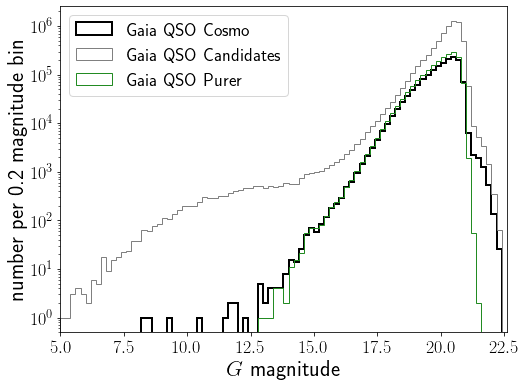

In [336]:
xlim = 5, 22.6
plt.figure(figsize=(8,6))
g_bins = np.arange(xlim[0], xlim[1], 0.2)
plt.hist(tab_gaia_all[idx_clean_gaia]['phot_g_mean_mag'], histtype='step', cumulative=False, 
         bins=g_bins, color='k', lw=2, label='Gaia QSO Cosmo')
plt.hist(tab_gaia_all['phot_g_mean_mag'], histtype='step', cumulative=False, 
         bins=g_bins, color='grey', lw=1, label='Gaia QSO Candidates')
plt.hist(tab_gaia_purer['phot_g_mean_mag'], histtype='step', cumulative=False, 
         bins=g_bins, color='forestgreen', lw=1, label='Gaia QSO Purer')
plt.yscale('log')
plt.xlim(xlim)

plt.xlabel(r'$G$ magnitude')
plt.ylabel('number per 0.2 magnitude bin')

plt.legend(loc='upper left')

fn = f'{plot_dir}/G_dist.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# Redshift improvement


In [254]:
G_max_spz = 20.5
#spz_tag = '_scaledNOqsoc'
spz_tag = '_wspzqsoc'
fn_spz = f'../data/redshifts_spz_kNN_G{G_max_spz}{spz_tag}.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [255]:
print(np.min(tab_spz['sdss_Z']), np.max(tab_spz['sdss_Z']))
idx_neg = tab_spz['sdss_Z']<0
print(tab_spz['sdss_Z'][idx_neg])
print(tab_spz['redshift_spz'][idx_neg])

-999.0 7.011244773864746
        sdss_Z        
----------------------
-0.0014524677535519004
 -0.002642691368237138
                -999.0
                -999.0
redshift_spz
------------
    1.624298
       1.043
    0.282998
       0.623


TODO: remove -999s from sdss cross matching !

TODO: what to do about these small negative SDSS redshifts? leave em?

In [256]:
print(len(tab_spz['sdss_Z']))
print(np.isfinite(tab_spz['sdss_Z'][0]))

1104830
--


In [257]:
# idk whats going on with this masking stuff??
print(np.ma.count_masked(tab_spz['sdss_Z']))
print(np.ma.count(tab_spz['sdss_Z']))

844711
260119


In [258]:
# for now, let's say it has to be positive
i_has_sdss_redshift = (tab_spz['sdss_Z'] > 0)
print(np.sum(i_has_sdss_redshift))

260115


In [259]:
z_sdss = tab_spz['sdss_Z'][i_has_sdss_redshift]
z_spz = tab_spz['redshift_spz'][i_has_sdss_redshift]
z_qsoc = tab_spz['redshift_qsoc'][i_has_sdss_redshift]
z_spzqsoc = tab_spz['redshift_spzqsoc'][i_has_sdss_redshift]

dz1pz_spz = (z_spz-z_sdss)/(1+z_sdss)
dz1pz_qsoc = (z_qsoc-z_sdss)/(1+z_sdss)
dz1pz_spzqsoc = (z_spzqsoc-z_sdss)/(1+z_sdss)

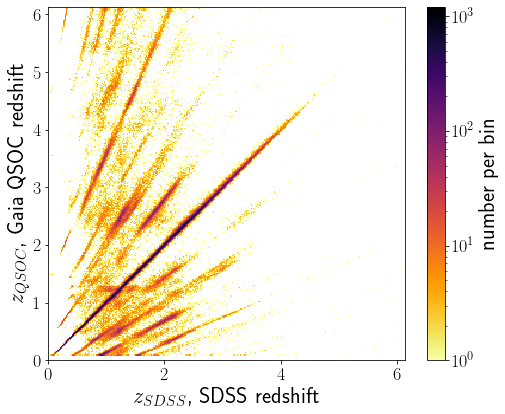

In [337]:
z_bins = np.linspace(0, np.max(z_qsoc), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss, z_qsoc, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm()
             )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{QSOC}$, Gaia QSOC redshift')

fn = f'{plot_dir}/redshift_qsoc_vs_sdss.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

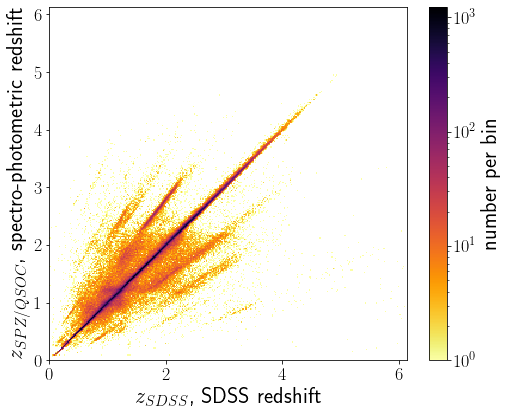

In [338]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss, z_spzqsoc, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ/QSOC}$, spectro-photometric redshift')

fn = f'{plot_dir}/redshift_spzqsoc_vs_sdss.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

## Cumulative dist

In [315]:
G_max = 20
idx_G = tab_spz['phot_g_mean_mag'][i_has_sdss_redshift] < G_max

In [316]:
dz1pz_bins_log = np.logspace(-4, np.log10(2), 50)

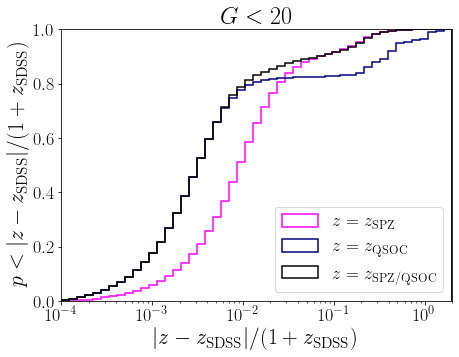

In [317]:
plt.figure(figsize=(7,5))
plt.title(rf'$G<{G_max}$', fontsize=24)
lw=1.5
plt.hist(abs(dz1pz_spz[idx_G]), bins=dz1pz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='magenta', label=r'$z=z_\mathrm{SPZ}$')
plt.hist(abs(dz1pz_qsoc[idx_G]), bins=dz1pz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='navy', label=r'$z=z_\mathrm{QSOC}$')
plt.hist(abs(dz1pz_spzqsoc[idx_G]), bins=dz1pz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='k', label=r'$z=z_\mathrm{SPZ/QSOC}$')
plt.xlabel(r'$|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.ylabel(r'$p < |z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right')

fn = f'{plot_dir}/redshift_error_cumulative.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

In [17]:
G_max_max = 20.4
idx_Gmax = tab_spz['phot_g_mean_mag'][i_has_sdss_redshift] < G_max_max

In [19]:
dz1pz_bins = np.linspace(np.min(dz1pz_qsoc), np.max(dz1pz_qsoc), 80)

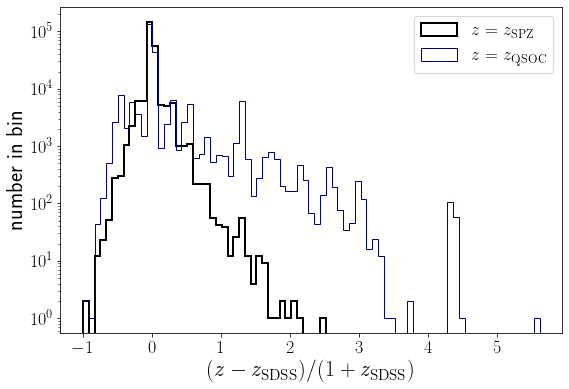

In [25]:
plt.figure(figsize=(9,6))
plt.hist(dz1pz_spzqsoc[idx_Gmax], bins=dz1pz_bins, histtype='step', 
         color='k', label=r'$z=z_\mathrm{SPZ}$', lw=2)
#plt.hist(dz1pz_spz[idx_Gmax], bins=dz1pz_bins, histtype='step', label=r'$z=z_\mathrm{SPZ}$')
plt.hist(dz1pz_qsoc[idx_Gmax], bins=dz1pz_bins, histtype='step', 
         color='navy', label=r'$z=z_\mathrm{QSOC}$')
plt.xlabel(r'$(z - z_\mathrm{SDSS})/(1 + z_\mathrm{SDSS})$')
plt.ylabel('number in bin')
plt.legend()
plt.yscale('log')

# Outlier fraction as function of G

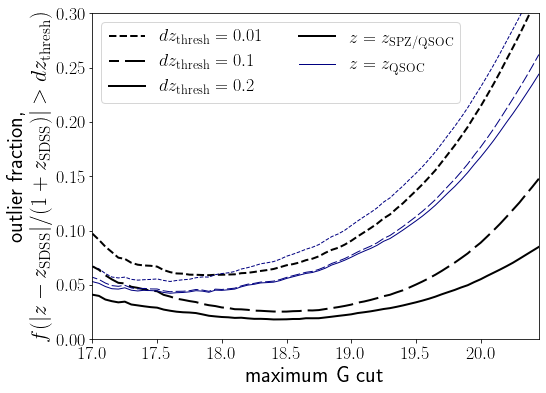

In [331]:
plt.figure(figsize=(8,6))
ax = plt.gca()

G_arr = tab_spz['phot_g_mean_mag'][i_has_sdss_redshift]
G_maxs = np.arange(17.0, 20.5, 0.05)

dz1pz_threshs = [0.01, 0.1, 0.2]
alphas = [0.4, 0.6, 0.8, 1]
lss = ['--', (5, (10,3)), '-']
for iz, dz1pz_thresh in enumerate(dz1pz_threshs):
    n_insample = np.empty(len(G_maxs), dtype=int)
    f_outliers_spzqsoc = np.empty(len(G_maxs))
    f_outliers_qsoc = np.empty(len(G_maxs))

    for i in range(len(G_maxs)):
        i_insample = G_arr < G_maxs[i]
        n_insample[i] = np.sum(i_insample)
        
        f_outliers_spzqsoc[i] = np.sum(np.abs(dz1pz_spzqsoc[i_insample]) > dz1pz_thresh) / n_insample[i]
        f_outliers_qsoc[i] = np.sum(np.abs(dz1pz_qsoc[i_insample]) > dz1pz_thresh) / n_insample[i]
        
    plt.plot(G_maxs, f_outliers_spzqsoc, color='k', alpha=1, ls=lss[iz], lw=2, label=fr'$dz_\mathrm{{thresh}}={dz1pz_thresh}$')
    plt.plot(G_maxs, f_outliers_qsoc, color='navy', alpha=1, ls=lss[iz], lw=1)

plt.xlabel("maximum G cut")
plt.ylabel('outlier fraction,\n' + r'$f(|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})|>dz_\mathrm{{thresh}})$')
plt.ylim(0, 0.3)
plt.xlim(np.min(G_maxs), np.max(G_maxs))


handles, labels = ax.get_legend_handles_labels()
line_spzqsoc = Line2D([], [], color='k', lw=2)#, label='$z=z_\mathrm{SPZ/QSOC}$')
line_qsoc = Line2D([], [], color='navy', lw=1)#, label='$z=z_\mathrm{QSOC}$')
handles.extend([line_spzqsoc, line_qsoc])
labels.extend(['$z=z_\mathrm{SPZ/QSOC}$', '$z=z_\mathrm{QSOC}$'])

plt.legend(handles, labels, ncol=2)


fn = f'{plot_dir}/redshift_outliers_vs_Gmax.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### print out stats

In [289]:
G_maxs = [20.0, 20.4]

dz1pz_threshs = [0.01, 0.1, 0.2]
alphas = [0.4, 0.6, 0.8, 1]
tol = 1e-6
for iz, dz1pz_thresh in enumerate(dz1pz_threshs):

    for i in range(len(G_maxs)):
        i_insample = G_arr < G_maxs[i]
        n_insample = np.sum(i_insample)
        
        f_outliers_spzqsoc = np.sum(np.abs(dz1pz_spzqsoc[i_insample]) > dz1pz_thresh) / n_insample
        f_outliers_qsoc = np.sum(np.abs(dz1pz_qsoc[i_insample]) > dz1pz_thresh) / n_insample
        
        print(f'G<{G_maxs[i]:.1f}')
        print(f'Frac. of outliers with |dz|>{dz1pz_thresh}:')
        print(f'SPZ/QSOC: {f_outliers_spzqsoc:.3f}')
        print(f'QSOC: {f_outliers_qsoc:.3f}')
        print()


G<20.0
Frac. of outliers with |dz|>0.01:
SPZ/QSOC: 0.214
QSOC: 0.232

G<20.4
Frac. of outliers with |dz|>0.01:
SPZ/QSOC: 0.305
QSOC: 0.320

G<20.0
Frac. of outliers with |dz|>0.1:
SPZ/QSOC: 0.089
QSOC: 0.177

G<20.4
Frac. of outliers with |dz|>0.1:
SPZ/QSOC: 0.140
QSOC: 0.251

G<20.0
Frac. of outliers with |dz|>0.2:
SPZ/QSOC: 0.055
QSOC: 0.168

G<20.4
Frac. of outliers with |dz|>0.2:
SPZ/QSOC: 0.081
QSOC: 0.234



## redshift dists

In [159]:
fn_gaia = f'../data/gaia_clean.fits'
tab_gaia = Table.read(fn_gaia, format='fits')

In [160]:
fn_sdss = '../data/sdss_slim.fits'
tab_sdss = Table.read(fn_sdss, format='fits')

In [326]:
idx_Gmaxmax = tab_spz['phot_g_mean_mag'] < 20.4

$z_\mathrm{SPZ/QSOC}$ (Gaia cosmo, $G<20.4$)
1.476
$z_\mathrm{QSOC}$ (Gaia cosmo, $G<20.4$)
1.582
$z_\mathrm{QSOC}$ (Gaia all)


/ext3/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


1.667
$z_\mathrm{QSOC}$ (Gaia purer)


/ext3/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


1.625
$z_\mathrm{SDSS}$ (SDSS all)
1.692


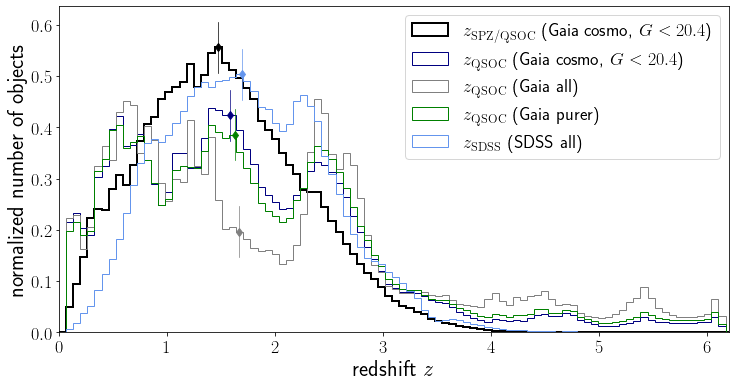

In [333]:
alpha = 1
lw = 1
density = True
histtype='step'
z_bins = np.linspace(0,6.5,100)

i_makeGcut = tab_gaia_all['phot_g_mean_mag'] < 20.5

z_data = [tab_spz['redshift_spzqsoc'][idx_Gmaxmax],
          tab_spz['redshift_qsoc'][idx_Gmaxmax],
          tab_gaia_all['redshift_qsoc'],
          tab_gaia_purer['redshift_qsoc'],
          tab_sdss['Z']
         ]

labels = [r'$z_\mathrm{SPZ/QSOC}$ (Gaia cosmo, $G<20.4$)',
          r'$z_\mathrm{QSOC}$ (Gaia cosmo, $G<20.4$)',
          r'$z_\mathrm{QSOC}$ (Gaia all)',
          r'$z_\mathrm{QSOC}$ (Gaia purer)',
          r'$z_\mathrm{SDSS}$ (SDSS all)'
         ]

colors = ['black', 'navy', 'grey', 'green', 'cornflowerblue']
lws = [2, 1, 1, 1, 1]

plt.figure(figsize=(12,6))

lw_med = 0.7
for ii in range(len(z_data)):
    print(labels[ii])

    ns, bs, _ = plt.hist(z_data[ii], bins=z_bins, alpha=alpha, color=colors[ii], lw=lws[ii], 
                 density=density, histtype=histtype, label=labels[ii])
    
    i_finite = np.isfinite(z_data[ii])
    z_med = np.median(z_data[ii][i_finite])
    bb = np.digitize(z_med, bs)
    nval = ns[bb-1]
    plt.plot([z_med]*2, [nval-0.05, nval+0.05], lw=lw_med, color=colors[ii])
    plt.plot(z_med, nval, marker='d', color=colors[ii])
    print(f'{z_med:.3f}')

plt.xlabel(r'redshift $z$')
plt.ylabel('normalized number of objects')
plt.legend()

plt.xlim(0,6.2)

fn = f'{plot_dir}/redshift_dists.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# Sky distribution, our catalog

## G < 20.4

In [141]:
#print(len(tab_spz))
idx_Gmaxmax = tab_gaia_all['phot_g_mean_mag'] < 20.4
idx_clean = idx_clean_gaia & idx_Gmaxmax
print(np.sum(idx_clean))

1076739


In [142]:
map_nqso, pixel_indices = maps.get_map(NSIDE, tab_gaia_all['ra'][idx_clean], tab_gaia_all['dec'][idx_clean], null_val=0)

In [143]:
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")
map_ndens = map_nqso/area_per_pixel

Area per pixel: 0.839 deg


In [144]:
map_ndens_masked = hp.ma(map_ndens)
map_ndens_masked.mask = map_ndens==0

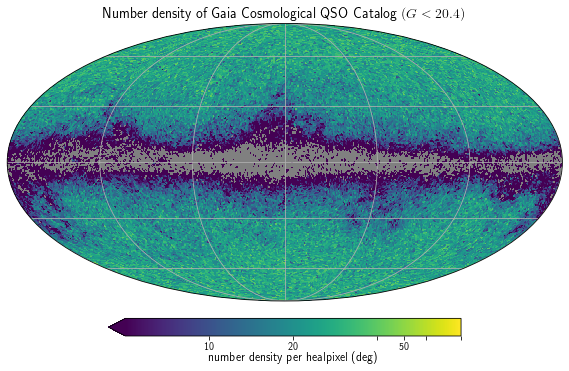

In [339]:
projview(map_ndens_masked, title=rf"Number density of Gaia Cosmological QSO Catalog $(G<20.4)$",
            unit=r"number density per healpixel (deg)", cmap='viridis', coord=['C', 'G'], 
            min=5, max=80, norm='log', graticule=True,
           show_tickmarkers=True, cbar_ticks=[10, 20, 50])

fn = f'{plot_dir}/gaia_qsos_20.4_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

## G < 20.0

In [32]:
#print(len(tab_spz))
idx_Gmaxmax = tab_gaia_all['phot_g_mean_mag'] < 20.0
idx_clean = idx_clean_gaia & idx_Gmaxmax
print(np.sum(idx_clean))

692526


In [33]:
map_nqso, pixel_indices = maps.get_map(NSIDE, tab_gaia_all['ra'][idx_clean], tab_gaia_all['dec'][idx_clean], null_val=0)
map_ndens = map_nqso/area_per_pixel
map_ndens_masked = hp.ma(map_ndens)
map_ndens_masked.mask = map_ndens==0

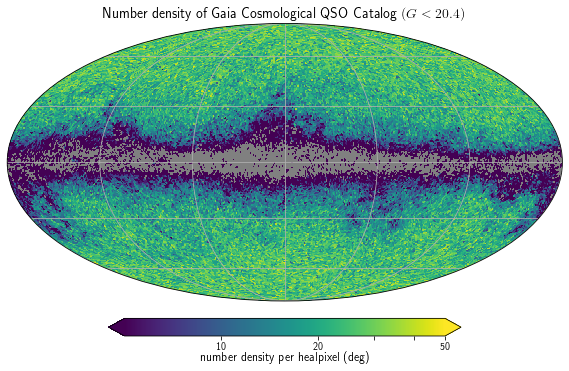

In [34]:
projview(map_ndens_masked, title=rf"Number density of Gaia Cosmological QSO Catalog $(G<20.4)$",
            unit=r"number density per healpixel (deg)", cmap='viridis', coord=['C', 'G'], 
            min=5, max=50, norm='log', graticule=True,
           show_tickmarkers=True, cbar_ticks=[10, 20, 50])

fn = f'{plot_dir}/gaia_qsos_20.0_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# Milliquas

In [74]:
fn_mill = '../data/milliquas.fits.zip'
tab_mill = utils.load_table(fn_mill)
print(len(tab_mill))

1453164


In [5]:
print(tab_mill.columns)

<TableColumns names=('RA','DEC','NAME','TYPE','RMAG','BMAG','COMMENT','R','B','Z','CITE','ZCITE','RXPCT','QPCT','XNAME','RNAME','LOBE1','LOBE2')>


In [73]:
values, counts = np.unique(tab_mill['CITE'], return_counts=True)

ind = np.argpartition(-counts, kth=10)[:10]
for i in ind:
    print(values[i], counts[i])  # prints the 10 most frequent elements
    
print('total:',np.sum(counts))

DR16Q  717418
WISEA  31676
MQ     459068
DR16   43263
2QZ    27534
GAIA3  23730
NBCKv3 26784
XDQSO  21214
PGC    20303
2SLAQ  10367
total: 1453164


In [ ]:
cites = set(tab_mill[''])

(array([  1038.,   1198.,   1330.,   1054.,   1323.,   1563.,   1702.,
          1728.,   2034.,   2349.,   3318.,   4519.,   6687.,  10292.,
         16022.,  31312.,  64643., 127506., 208807., 257575., 193263.,
        165885., 158522.,  95089.,  42354.,  18516.,   9653.,   4468.,
          1839.]),
 array([10.        , 10.51724138, 11.03448276, 11.55172414, 12.06896552,
        12.5862069 , 13.10344828, 13.62068966, 14.13793103, 14.65517241,
        15.17241379, 15.68965517, 16.20689655, 16.72413793, 17.24137931,
        17.75862069, 18.27586207, 18.79310345, 19.31034483, 19.82758621,
        20.34482759, 20.86206897, 21.37931034, 21.89655172, 22.4137931 ,
        22.93103448, 23.44827586, 23.96551724, 24.48275862, 25.        ]),
 <BarContainer object of 29 artists>)

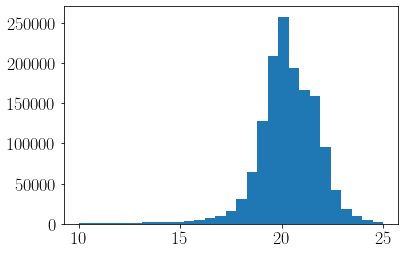

In [38]:
plt.hist(tab_mill['RMAG'], bins=np.linspace(10, 25, 30))

In [57]:
map_nqso_mill, pixel_indices_mill = maps.get_map(NSIDE, tab_mill['RA'], tab_mill['DEC'], null_val=0)
map_ndens_mill = map_nqso_mill/area_per_pixel
map_ndens_mill_masked = hp.ma(map_ndens_mill)
map_ndens_mill_masked.mask = map_ndens_mill==0

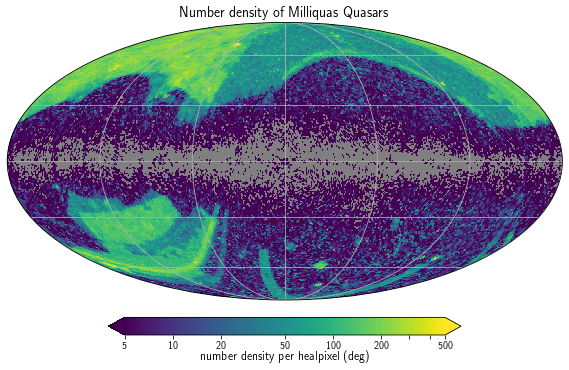

In [58]:
projview(map_ndens_mill_masked, title=rf"Number density of Milliquas Quasars",
            unit=r"number density per healpixel (deg)", cmap='viridis', coord=['C', 'G'], 
            min=5, max=500, norm='log', graticule=True,
           show_tickmarkers=True, cbar_ticks=[5, 10, 20, 50, 100, 200, 500])

fn = f'{plot_dir}/gaia_qsos_milliquas_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### with G_max

In [59]:
# via https://www.notion.so/Gaia-Quasars-for-LSS-71cffab9f4f34a058e78385c6a565a97#d0046413724a49439c2ecdbdb7d604b9
G_from_r = 0.97 * tab_mill['RMAG'] + 0.39

In [60]:
idx_Gmax_from_r = G_from_r < 20.4
print(np.sum(idx_rmax), len(idx_rmax), np.sum(idx_rmax)/len(idx_rmax))
map_nqso_mill, pixel_indices_mill = maps.get_map(NSIDE, tab_mill['RA'][idx_Gmax_from_r], 
                                                 tab_mill['DEC'][idx_Gmax_from_r], null_val=0)
map_ndens_mill = map_nqso_mill/area_per_pixel
map_ndens_mill_masked = hp.ma(map_ndens_mill)
map_ndens_mill_masked.mask = map_ndens_mill==0

784360 1453164 0.5397601371902965


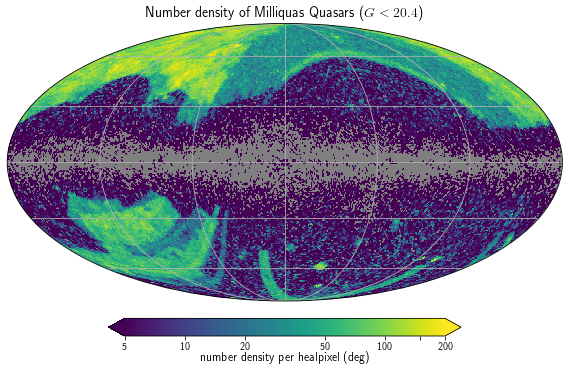

In [75]:
projview(map_ndens_mill_masked, title=rf"Number density of Milliquas Quasars ($G<20.4$)",
            unit=r"number density per healpixel (deg)", cmap='viridis', coord=['C', 'G'], 
            min=5, max=200, norm='log', graticule=True,
           show_tickmarkers=True, cbar_ticks=[5, 10, 20, 50, 100, 200])

fn = f'{plot_dir}/gaia_qsos_milliquas_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')